<a href="https://colab.research.google.com/github/Milonahmed96/Credit-Risk-AI/blob/main/notebooks/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup & Data Acquisition
In this phase, we import our libraries, set a premium visual style for our charts, and fetch the dataset.

In [1]:
# import library for mounting
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Create a specific folder for this project in your Drive
project_path = '/content/drive/MyDrive/Ahmed Intelligence/AI for Banking and Fintech'
if not os.path.exists(project_path):
    os.makedirs(project_path)

Mounted at /content/drive


In [2]:
# import necessary libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Premium visualization technique
plt.rcParams.update({
    'font.family': 'sans-serif',
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    'axes.labelsize': 13,
    'axes.labelweight': 'bold',
    'axes.labelpad': 10,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12,
    'legend.title_fontsize': 13,
    'figure.dpi': 120
})

sns.set_style("whitegrid", {"axes.edgecolor": ".8", "grid.color": ".9", "grid.linestyle": "--"})

# Corporate Risk Palette: Good/Safe = Blue-Green, Bad/Default = Crimson Red
BANKING_PALETTE = ["#20B2AA", "#DC143C"]
sns.set_palette(BANKING_PALETTE)

# DATA LOADING
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
print("Fetching banking dataset from UCI...")
df = pd.read_excel(url, header=1)

# Standardize columns
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.rename(columns={'default_payment_next_month': 'default'}, inplace=True)
df.drop('id', axis=1, inplace=True)

print(f"{df.shape[0]} rows, {df.shape[1]} columns.")

Fetching banking dataset from UCI...
30000 rows, 24 columns.


In [3]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Target Imbalance & Data Cleaning
We must establish our baseline default rate to justify our evaluation metrics later. We also clean undocumented demographic values (like `0, 5, 6` in Education) by mapping them to the "Others" category to prevent the model from learning noise.

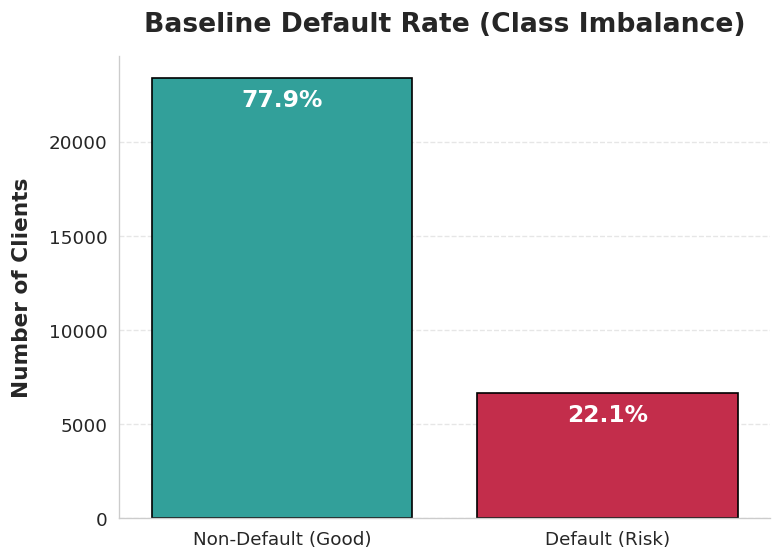

In [4]:
# Data Cleaning
df['education'] = df['education'].replace([0, 5, 6], 4)
df['marriage'] = df['marriage'].replace(0, 3)

# Visualizing the Class Imbalance
plt.figure(figsize=(7, 5))
ax = sns.countplot(data=df, x='default', palette=BANKING_PALETTE, edgecolor='black', linewidth=1)

# Formatting the plot
plt.title('Baseline Default Rate (Class Imbalance)')
plt.xticks([0, 1], ['Non-Default (Good)', 'Default (Risk)'])
plt.ylabel('Number of Clients')
plt.xlabel('')

# Adding clean percentage labels inside the bars
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() - 1500 # Position slightly below the top
    ax.text(x, y, percentage, ha='center', color='white', fontweight='bold', fontsize=14)

sns.despine()
plt.show()

# Credit-Risk Driven EDA
We explore the relationship between financial capacity (Credit Limit) and historical delinquency (Repayment Status) to find the business drivers of default.

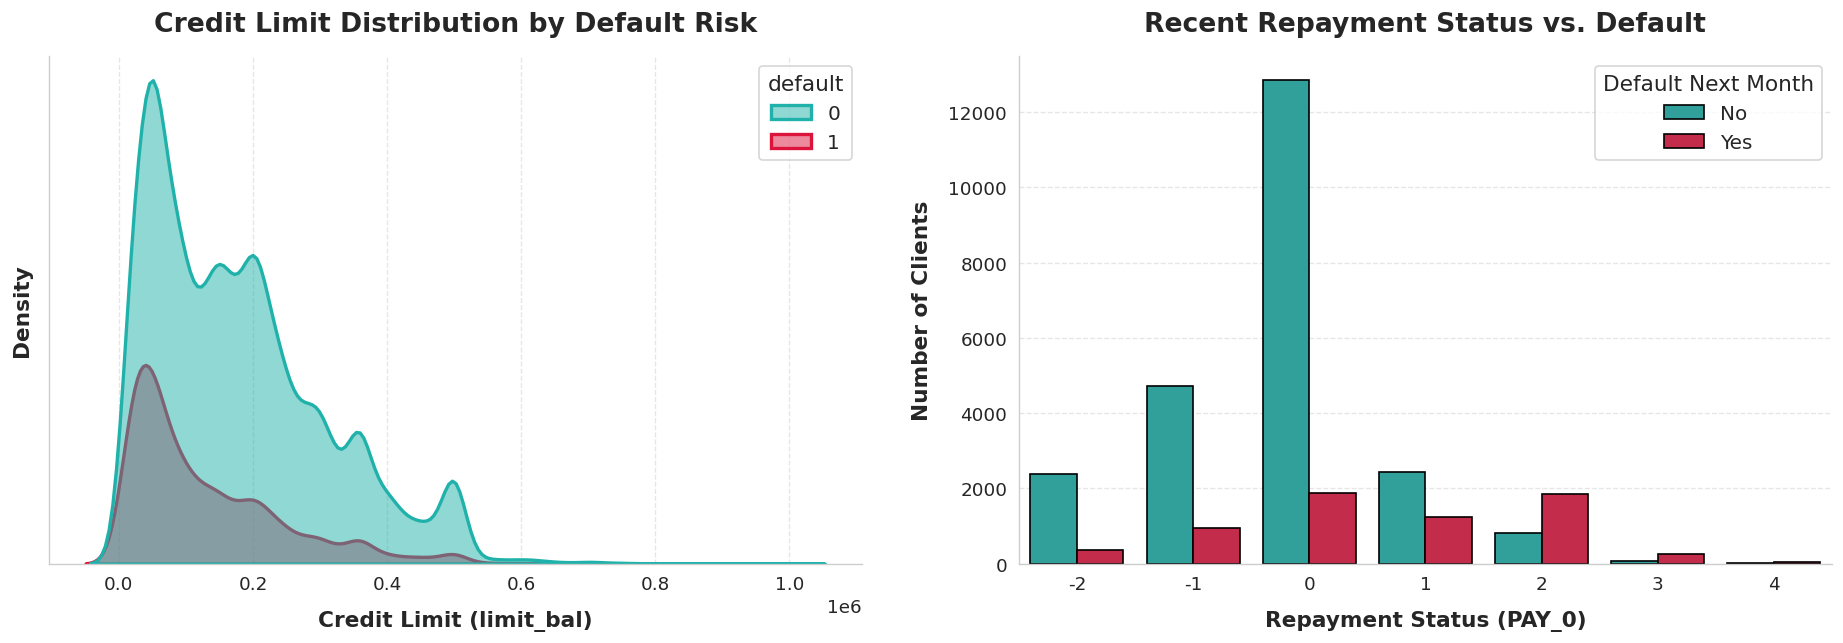

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1:Credit Limit Density
sns.kdeplot(data=df, x='limit_bal', hue='default', fill=True, alpha=0.5, linewidth=2,
            palette=BANKING_PALETTE, ax=axes[0])
axes[0].set_title('Credit Limit Distribution by Default Risk')
axes[0].set_xlabel('Credit Limit (limit_bal)')
axes[0].set_ylabel('Density')
axes[0].get_yaxis().set_ticks([])

# Plot 2: Recent Payment Status
# Filter out extreme outliers for a cleaner view (focus on -2 to 4 months late)
plot_df = df[df['pay_0'].between(-2, 4)]
sns.countplot(data=plot_df, x='pay_0', hue='default', palette=BANKING_PALETTE,
              edgecolor='black', ax=axes[1])
axes[1].set_title('Recent Repayment Status vs. Default')
axes[1].set_xlabel('Repayment Status (PAY_0)')
axes[1].set_ylabel('Number of Clients')
axes[1].legend(title='Default Next Month', labels=['No', 'Yes'], loc='upper right')

sns.despine()
plt.tight_layout(pad=3.0)
plt.show()

# Banking Feature Engineering & Preprocessing
We engineer high-value banking metrics to give the raw data business context:
1. `utilization_ratio`: Exhaustion of credit limit.
2. `pay_to_bill_ratio`: Identifies "transactors" vs. "revolvers".
3. `avg_payment_delay`: Smooths historical delinquency.
4. `bill_trend`: Captures the velocity of debt.

Finally, we process the data strictly preventing data leakage by splitting before scaling, and save it for modeling.

In [6]:
# Advanced Feature Engineering
df['utilization_ratio'] = (df['bill_amt1'] / df['limit_bal']).clip(lower=0)
df['pay_to_bill_ratio'] = np.where(df['bill_amt1'] > 0, df['pay_amt1'] / df['bill_amt1'], 1.0)
df['pay_to_bill_ratio'] = np.clip(df['pay_to_bill_ratio'], 0, 1)

pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df['avg_payment_delay'] = df[pay_cols].clip(lower=0).mean(axis=1)
df['bill_trend'] = df['bill_amt1'] - df['bill_amt6']

# Define X and y (NO encoding or scaling yet!)
X = df.drop('default', axis=1)
y = df['default']

# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save Raw Engineered Data for Pipelines
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save directly to your Google Drive
train_data.to_csv(f'{project_path}/train_processed.csv', index=False)
test_data.to_csv(f'{project_path}/test_processed.csv', index=False)